# Functional Encryption - Classification and information leakage
 
### Purpose

We try here to assess the resistance of a model to multiple collateral adversaries when resistance has been built agains a single big adversary, a CNN.

The adversaries tested against are naturally the FNN and CNN seens earlier, but also more classical models. We have tried almost exhaustively the sklearn library and observe very different performance between the models on the colateral task.


## 1. Parameters and imports


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [3]:
torch.set_num_threads(4)

In [4]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Some utility functions

In [5]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset


def get_datasets():
    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)
    
    return train_dataset, test_dataset

def get_data_loaders():
    torch.manual_seed(1)
    args = Parser()

    train_dataset, test_dataset = get_datasets()

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    return train_loader, test_loader

## 2. Building resistance

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [6]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- Junction
        self.jct = nn.Linear(8, 784)
        
        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [7]:
import torch

In [8]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_collateral):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        
        # Phase 1
        if initial_phase: # Optimise Q + C
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
        elif perturbate: # Optimise Freezed(Q) + C
            model.freeze('quad')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)
            loss_char.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 2
        if (initial_phase or perturbate): # Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
        elif new_collateral: # Optimise Freezed(Q) + new F
            model.freeze('quad')
            optimizer.zero_grad()
            output_font = model.forward_adv_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 3
        if perturbate: # Optimize Q
            model.freeze('font')
            model.freeze('char')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)

            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)

            loss = loss_char - alpha * loss_font
            loss.backward()
            optimizer.step()
            model.unfreeze()
            
            
        if new_collateral:
            loss_char = torch.zeros(1)
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char.item(), loss_font.item()))

In [9]:
def test(args, model, test_loader, new_adversary):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            if not new_adversary:
                output = model.forward_char(data)
                pred = output.argmax(1, keepdim=True)
                correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not new_adversary:
                output = model.forward_font(data)
            else:
                output = model.forward_adv_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

In [10]:
def build_resistance(model, alpha=0):
    """
    Perform a learning + a sabotage phase
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        new_adversary = False
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [11]:
path = '../data/models/quadconvnet_part17.pt'
model = QuadConvNet()
results = {}

try:
    model.load_state_dict(torch.load(path))
    model.eval()
    print('Model loaded!')
except FileNotFoundError:
    print('Computing model...')
    alpha=1.5
    test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate
    
    model.results = results
    # save model
    torch.save(model.state_dict(), path)

Model loaded!


# 3. Testing resistance with multiple models

In [12]:
quadratic_model = model
quadratic_model.freeze('quad')

In [13]:
def evaluate_resistance(model, alpha=0):
    """
    Perform a learning + a sabotage phase
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        new_adversary = True
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [14]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [15]:
resistance_reports = {}

## 3.1 Fully connected models 

In [72]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = 8
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.629146
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.625484
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.614050
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.607452
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.606081
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.590423
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.615271
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.578101
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.590999
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.601180

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2397/10000 (23.97%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.577466
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0.


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2921/10000 (29.21%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.725975
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.604582
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.622184
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.624310
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.602119
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.611288
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.600381
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.609032
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.609720
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.588954

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2273/10000 (22.73%)
Train Epoch: 2 [0/60000 (0%)

Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.533692
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.571914

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2642/10000 (26.42%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 2.750403
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.654245
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.621393
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.638778
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.600552
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.626825
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.589068
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.611565
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.623794
Train Epoch: 1 [57600/60000 (96%)]	Loss 

Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.548662
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.544883
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.607075

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2513/10000 (25.13%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 9.656064
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.795056
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.699390
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.727127
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.632308
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.598947
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.624567
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.529872
Train Epoch: 1 [51200/60000 (85%)]	Loss

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.565489
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.481735
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.402487
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.550917

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 3149/10000 (31.49%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 2.825813
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.688153
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.643066
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.702604
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.603987
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.615662
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.589470
Train Epoch: 1 [44800/60000 (75%)]	Los

Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.510247
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.554902
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.514219
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.519567
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.611885

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2843/10000 (28.43%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 12.157612
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.734431
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.632718
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.668840
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.602250
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.574155
Train Epoch: 1 [38400/60000 (64%)]	L

Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.563898
Train Epoch: 10 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.544111
Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.569924
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.593858
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.512397
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.547071
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.627336

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2743/10000 (27.43%)


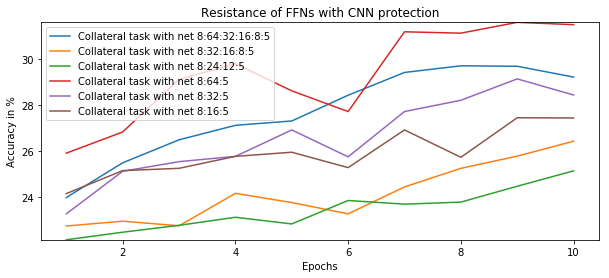

In [73]:
architectures = [[64, 32, 16, 8], [32, 16, 8], [24, 12], [64], [32], [16]]

for architecture in architectures:
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


## 3.2 CNN models

In [17]:
class CNNet2(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet2, self).__init__(quadratic_model)

        self.jc = nn.Linear(8, 784)
            
        self.cv1 = nn.Conv2d(1, 20, 5, 1)
        self.cv2 = nn.Conv2d(20, 50, 5, 1)
        self.ln1 = nn.Linear(4*4*50, 500)
        self.ln2 = nn.Linear(500, N_FONTS)
    
    def conv_font(self, x):
        
        x = self.jc(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.cv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.cv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x
         

In [22]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(8, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
         

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 2.120065
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.585263
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.595706
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.617869
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.571451
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.591128
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.578578
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.572873
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.561263
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.570320

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2769/10000 (27.69%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.583106
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0.

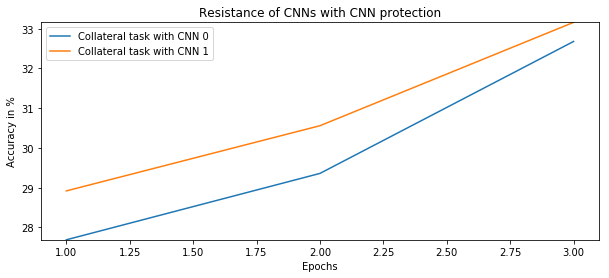

In [23]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 500),
        nn.Linear(500, N_FONTS)
    ),
    (
        nn.Conv2d(1, 30, 4, 1),
        nn.Conv2d(30, 100, 4),
        nn.Linear(100 * 4 * 4, 1000),
        nn.Linear(1000, 100),
        nn.Linear(100, N_FONTS)
    )
]
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

## 3.3 Non-DL models

### Data preparation

In [18]:
transform = BaseNet(quadratic_model)

In [19]:
def get_input_onehot_labels(dataset, label="font", one_hot=True):
    data_input = dataset.tensors[0]
    label_idx = {'char': 0, 'font': 1}[label]
    label_size = {'char': 26, 'font': 5}[label]
    labels = dataset.tensors[1][:, label_idx].view(-1, 1)
    
    data_label_onehot = torch.zeros(len(labels), label_size)
    data_label_onehot.scatter_(1, labels, 1)
    
    return data_input, labels, data_label_onehot
    

Get dataset and transform in one hot vector

In [20]:
train_dataset, test_dataset = get_datasets()
train_input, train_label, train_label_one_hot = get_input_onehot_labels(train_dataset, label="font")
test_input, test_label, test_label_one_hot = get_input_onehot_labels(test_dataset, label="font")

Training set 60000 items
Testing set  10000 items


Apply the quadratic model transformation

In [21]:
train_input = transform.quad(train_input).detach().numpy()
test_input = transform.quad(test_input).detach().numpy()

In [22]:
train_input.shape, train_label.shape

((60000, 8), torch.Size([60000, 1]))

In [23]:
ALL = train_input.shape[0]
CPOWER = 'LOW'

In [24]:
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import svm

In [25]:
def evaluate_sklearn(reg, one_hot=True, limit=int(10e10)):
    train_labels = {True: train_label_one_hot, False: train_label}[one_hot]
    reg.fit(train_input[:limit], train_labels[:limit].detach().numpy()) 
    output = reg.predict(test_input)
    if one_hot:
        pred = torch.tensor(output).argmax(1, keepdim=True)
    else:
        if isinstance(output, list):
            pred = torch.tensor(list(map(round, output))).long().view(-1, 1)
        else:
            pred = torch.tensor(np.round(output)).long().view(-1, 1)
    y = test_label.view_as(pred)
    acc = pred.eq(y).sum().item() / len(pred)
    return acc

### Linear models

In [85]:
reg = linear_model.Ridge(alpha=.9)
acc = evaluate_sklearn(reg)
print(acc)
resistance_reports['linear model Ridge'] = acc * 100

0.2639


In [86]:
reg = linear_model.RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100], cv=5)
acc = evaluate_sklearn(reg)
print(acc)

0.2639


In [31]:
reg = linear_model.Lasso(alpha=0.1)
acc = evaluate_sklearn(reg)
print(acc)
resistance_reports['linear model Lasso'] = acc * 100

0.3082


In [32]:
reg = linear_model.LassoLars(alpha=0.1)
acc = evaluate_sklearn(reg)
print(acc)

0.1975


In [33]:
reg = linear_model.BayesianRidge()
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)

0.1938


/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
reg = linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', max_iter=1000)
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)
resistance_reports['logistic regression'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3208


In [35]:
reg = linear_model.LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial')
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklear

0.3208


### Quadratic Discriminant Analysis

In [36]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [37]:
clf = QuadraticDiscriminantAnalysis()
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Quadratic Discriminant Analysis'] = acc * 100

0.4062
CPU times: user 69.9 ms, sys: 15.9 ms, total: 85.8 ms
Wall time: 22.4 ms


/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Kernel Ridge

In [218]:
clf = kernel_ridge.KernelRidge(alpha=1.0)
acc = evaluate_sklearn(clf, one_hot=False, limit=15000)
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=8.74644e-10): result may not be accurate.
  overwrite_a=False)


0.2045
CPU times: user 41.7 s, sys: 2.69 s, total: 44.4 s
Wall time: 16.4 s


### SVM

In [212]:

clf = svm.SVC(gamma='scale', kernel='linear')
acc = evaluate_sklearn(clf, one_hot=False, limit=5000)
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2598
CPU times: user 16 s, sys: 72.6 ms, total: 16 s
Wall time: 15.9 s


In [38]:

clf = svm.SVC(gamma='scale', kernel='rbf')
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)
resistance_reports['SVM (rbf)'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5114
CPU times: user 14.9 s, sys: 278 ms, total: 15.2 s
Wall time: 15 s


In [216]:

clf = svm.SVC(gamma='scale', kernel='poly', coef0=0)
acc = evaluate_sklearn(clf, one_hot=False, limit=20000)
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2766
CPU times: user 15.5 s, sys: 222 ms, total: 15.7 s
Wall time: 15.7 s


In [217]:

clf = svm.SVC(gamma='scale', kernel='sigmoid', coef0=0)
acc = evaluate_sklearn(clf, one_hot=False, limit=20000)
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1821
CPU times: user 13.2 s, sys: 110 ms, total: 13.3 s
Wall time: 13.4 s


### Stochastic gradient Descent

In [39]:
clf = linear_model.SGDClassifier(loss="hinge", penalty="l2")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['SGDClassifier'] = acc * 100

0.2579


/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss="log")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2742


### K-Neighbors Classifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:

clf = KNeighborsClassifier(n_neighbors=7)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['K-Neighbors Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.7004
CPU times: user 940 ms, sys: 45.6 ms, total: 986 ms
Wall time: 726 ms


### Gaussian process (not scalable)

In [43]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [44]:

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0)
acc = evaluate_sklearn(gpc, one_hot=False, limit=400)
print(acc)
resistance_reports['Gaussian process'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2124
CPU times: user 14.8 s, sys: 2.8 s, total: 17.6 s
Wall time: 2.86 s


### Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB

In [46]:

gnb = GaussianNB()
acc = evaluate_sklearn(gnb, one_hot=False)
print(acc)

0.3151
CPU times: user 56.3 ms, sys: 15 ms, total: 71.3 ms
Wall time: 19.2 ms


/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Decision Tree Classifier

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:

clf = DecisionTreeClassifier(max_depth=5)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

resistance_reports['Decision Tree Classifier'] = acc * 100

0.3704
CPU times: user 245 ms, sys: 8.81 ms, total: 254 ms
Wall time: 253 ms


### Ensemble methods

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [93]:

clf = RandomForestClassifier(max_depth=30, n_estimators=100, max_features=4)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Random Forest Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.5785
CPU times: user 22.8 s, sys: 210 ms, total: 23 s
Wall time: 23.1 s


In [36]:
%%time
clf = AdaBoostClassifier(n_estimators=200, learning_rate=1.)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['AdaBoost Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2896
CPU times: user 12 s, sys: 31.7 ms, total: 12 s
Wall time: 12 s


In [52]:

clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=10, random_state=0)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Gradient Boosting Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6007
CPU times: user 18.7 s, sys: 57 ms, total: 18.8 s
Wall time: 18.8 s


### (sklearn) Neural Network

In [53]:
from sklearn.neural_network import MLPClassifier

In [54]:

clf = MLPClassifier(solver='lbfgs', alpha=1,
                    hidden_layer_sizes=(10, 40, 10), random_state=1)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4508
CPU times: user 49.4 s, sys: 5.35 s, total: 54.8 s
Wall time: 13.9 s


## Summary

In [19]:
def print_table(results):
    n_cols = 2
    title_length = 0
    for title in results.keys():
        title_length = max(title_length, len(title))
    result_length = 8
    table_length = 1 + n_cols + title_length + result_length
    sep = '+'.join(
        ['', '-'*title_length, '-'*result_length, '']
    )
    for title, serie in results.items():
        print(sep)
        title = (title + ' '*title_length)[:title_length]
        if isinstance(serie, list):
            result = round(np.mean(serie[-4:]), 2)
        else:
            result = round(serie, 2)
        result = (' ' +str(result) + '%' + ' '*result_length)[:result_length]
        line = '|'.join(
            ['', title, result, '']
        )
        print(line)
    print(sep)

In [ ]:
print_table(resistance_reports)

### Compative results

+---------------------------------------+--------+--------+
| Model                                 | Basic  |Resisted| 
+---------------------------------------+--------+--------+
|Collateral task with net 8:64:32:16:8:5| 49.1%  | 29.5%  |
+---------------------------------------+--------+--------+
|Collateral task with net 8:32:16:8:5   | 47.76% | 25.46% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:24:12:5     | 46.4%  | 24.26% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:64:5        | 52.29% | 31.34% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:32:5        | 48.47% | 28.37% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:16:5        | 41.96% | 26.88% |
+---------------------------------------+--------+--------+
|linear model Ridge                     | 31.75% | 26.39% |
+---------------------------------------+--------+--------+
|linear model Lasso                     | 30.82% | 25.36% |
+---------------------------------------+--------+--------+
|logistic regression                    | 32.08% | 26.15% |
+---------------------------------------+--------+--------+
|Quadratic Discriminant Analysis        | 40.62% | 30.19% |
+---------------------------------------+--------+--------+
|SVM (rbf)                              | 51.14% | 28.59% |
+---------------------------------------+--------+--------+
|SGDClassifier                          | 25.79% | 24.69% |
+---------------------------------------+--------+--------+
|K-Neighbors Classifier                 | 70.04% | 56.75% | *
+---------------------------------------+--------+--------+
|Gaussian process                       | 21.24% | 20.39% |
+---------------------------------------+--------+--------+
|Decision Tree Classifier               | 37.04% | 28.48% |
+---------------------------------------+--------+--------+
|Random Forest Classifier               | 69.5%  | 55.87% | *
+---------------------------------------+--------+--------+
|AdaBoost Classifier                    | 37.34% | 28.69% |
+---------------------------------------+--------+--------+
|Gradient Boosting Classifier           | 60.07% | 45.02% | *
+---------------------------------------+--------+--------+
|Collateral task with CNN 0             |        | 45.7%  | *
+---------------------------------------+--------+--------+
|Collateral task with CNN 1             |        | 45.5%  | *
+---------------------------------------+--------+--------+


## Conclusion
Overall, the models which use linear components behave quite poorly, while those based on completely different learning approaches (like K-Neighbors Classifier or Random Forest Classifier for example) manage to keep a pretty good accuracy in general. They also suffer from substantial accuracy drop in the sabotage setting (-15pt, while others loose more than 20pt), but as their initial performance was really good, they stand as outliers and robust adversaries which can help disclosing meaningful and sensitive information. For example, the K-Neighbors Classifier  succeeds in its predictions almost 3 times out of 5.